In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autograd
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
import math

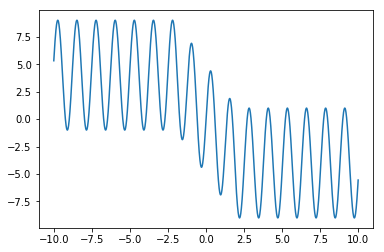

In [2]:
#построение графика функции
func = lambda x: abs(x-2) - abs(x+2) + 5*np.sin(5*x)
# dx Шаг между точками
dx = 0.01
xlist = np.arange(start = -10, stop = 10, step = dx)
ylist = [func(x) for x in xlist]
plt.plot(xlist, ylist)
plt.savefig('ini_func.png', bbox_inches='tight')

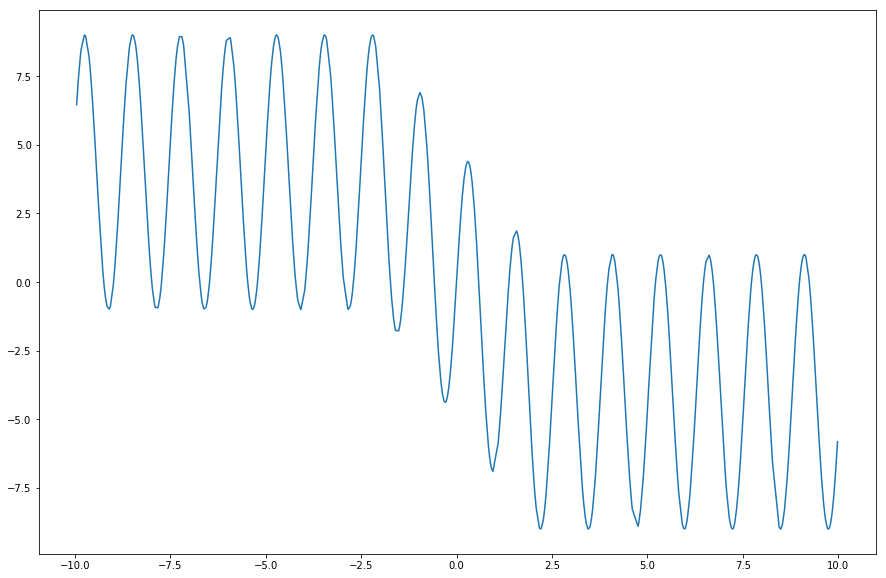

In [3]:
#Формирование исходных данных
#рандомно выберем точки на оси Х
X_data = 20 * (np.random.random(800) - 0.5)
X_data.sort()
Y_data = [func(x) for x in X_data]
data = np.array(list(zip(X_data, Y_data)))

plt.figure(figsize=(15,10))
plt.plot(data[:, 0], data[:, 1])

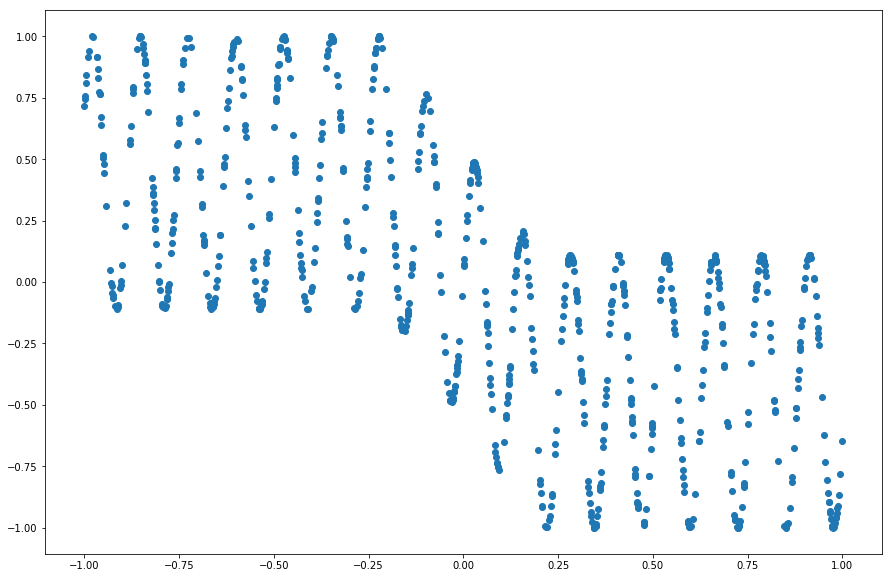

In [4]:
# Преобразование данных
data = preprocessing.minmax_scale(data, feature_range=(-1,1))

plt.figure(figsize=(15,10))
plt.scatter(data[:, 0], data[:, 1])

In [5]:
#премешать
np.random.shuffle(data)
print(data[:5])

[[-0.84065993  0.90320646]
 [-0.51941592  0.09757198]
 [-0.2751959  -0.0437128 ]
 [ 0.55324425 -0.11315723]
 [-0.49041609  0.83141501]]



 480 240 80


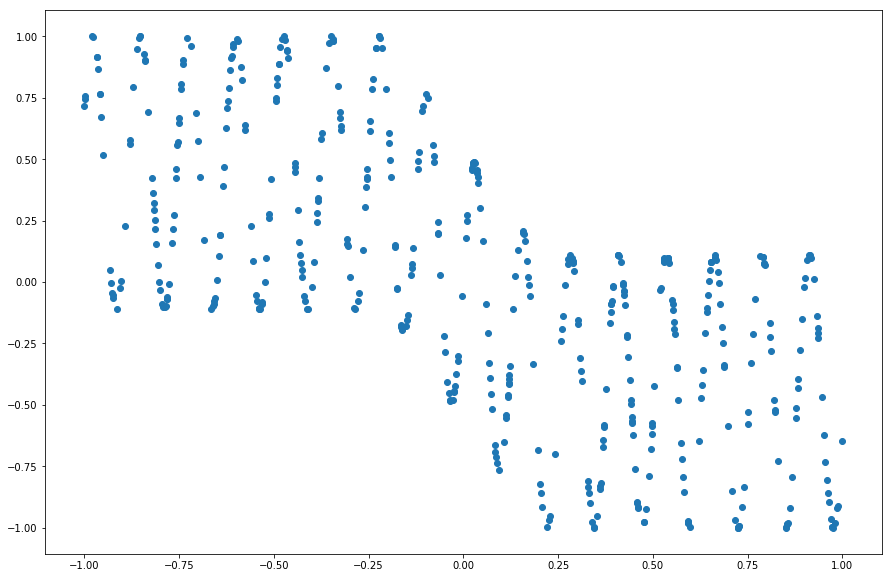

In [6]:
#отметим границы
train_border = [0, int(len(data)*0.6)]
valid_border = [int(len(data)*0.6), int(len(data)*0.9)]
test_border = [int(len(data)*0.9), len(data)]

#делим 
learn_data = data[train_border[0]: train_border[1]]
valid_data = data[valid_border[0]: valid_border[1]]
test_data = data[test_border[0]: test_border[1]]

print('\n', len(learn_data), len(valid_data), len(test_data))
plt.figure(figsize=(15, 10))
plt.scatter(learn_data[:, 0], learn_data[:, 1])


In [7]:
class SinDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [8]:
dataset = SinDataset(learn_data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

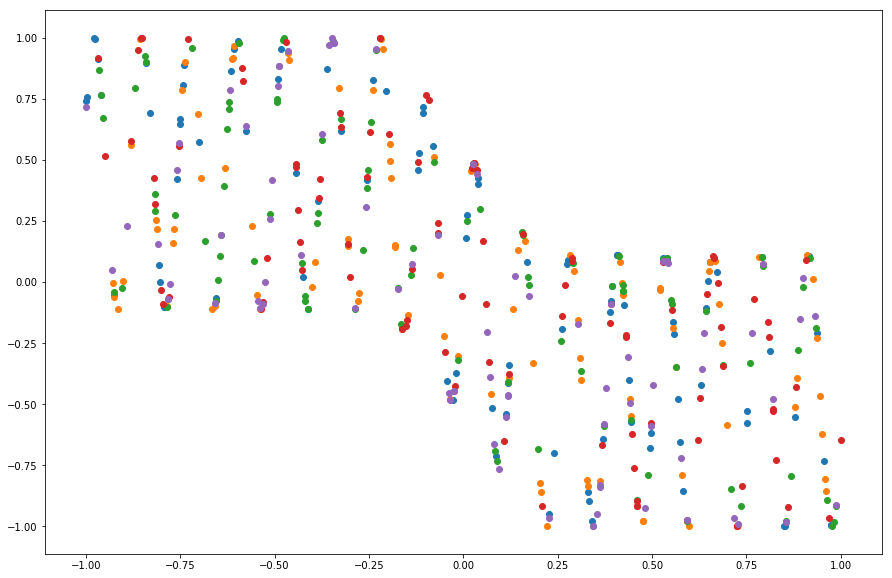

In [9]:
plt.figure(figsize=(15, 10))
for i in dataloader:
    plt.scatter(i[:, 0], i[:, 1])

In [10]:
class MainNet(nn.Module):
    def __init__(self):
        super(MainNet, self).__init__()
        self.lin1 = nn.Linear(1, 200)
        self.lin2 = nn.Linear(200, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.tanh(x)
        x = self.lin2(x)
        x = F.tanh(x)
        return x

In [11]:
net = MainNet()
net

MainNet(
  (lin1): Linear(in_features=1, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=1, bias=True)
)

In [12]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>




Columns 0 to 9 
-0.7490 -0.0848 -0.6074  0.6909  0.4621  0.0548  0.5796 -0.9232 -0.3181  0.3024

Columns 10 to 19 
 0.2229 -0.4568 -0.8109  0.7835 -0.5750 -0.4743 -0.3612 -0.1400  0.4150  0.1228

Columns 20 to 29 
-0.2980 -0.3669  0.0050 -0.1896 -0.4933  0.1163 -0.5585  0.1632  0.5072 -0.2036

Columns 30 to 39 
 0.7900  0.4173  0.0467  0.0464  0.6177 -0.9411  0.5585 -0.7641  0.2167  0.5269

Columns 40 to 49 
-0.7438  0.3886 -0.5742 -0.3898  0.2912 -0.3292 -0.1406 -0.4320  0.2251 -0.7979

Columns 50 to 59 
-0.8927  0.1594 -0.6634 -0.4821  0.7762 -0.5308  0.4633 -0.6079  0.5248  0.3715

Columns 60 to 69 
 0.1766 -0.9109  0.8093  0.8155 -0.7973 -0.0599  0.9381 -0.0520 -0.0961  0.7202

Columns 70 to 79 
-0.8484 -0.3556  0.7337 -0.3308 -0.7742  0.9894  0.1040  0.6294  0.4247 -0.3919

Columns 80 to 89 
 0.6885  0.2724 -0.7537 -0.2346 -0.6949 -0.4969 -0.4522  0.8655 -0.0715 -0.5658

Columns 90 to 99 
 0.5089  0.1573  0.9630  0.3189  0.2209  0.0816  0.2486  0.8370 -0.5410  0.2489

Columns 10

In [13]:
stds = [math.sqrt(2/202), math.sqrt(2/202)]
stds.reverse()
def init_weights(layer):
    if (type(layer) == nn.Linear):
        layer.weight.data = torch.randn(layer.weight.data.shape)*stds.pop()
        
net.apply(init_weights)

MainNet(
  (lin1): Linear(in_features=1, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=1, bias=True)
)

In [14]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>




Columns 0 to 9 
-0.0986 -0.0013 -0.0278  0.0430  0.0170  0.0938  0.2049 -0.1408  0.0633 -0.0844

Columns 10 to 19 
 0.0533 -0.0271  0.0250  0.0048 -0.0787 -0.2668  0.0373  0.0155 -0.0012 -0.0465

Columns 20 to 29 
 0.0165 -0.0412 -0.1258  0.1611 -0.2246  0.0005 -0.0552 -0.1924  0.0319  0.0494

Columns 30 to 39 
 0.0204 -0.0049  0.0386  0.1869  0.1467  0.0550 -0.0654  0.1074 -0.1494 -0.0454

Columns 40 to 49 
 0.0743 -0.0708  0.0134 -0.0735  0.1097 -0.0762  0.0435 -0.0357 -0.0265  0.0907

Columns 50 to 59 
-0.1042  0.0360  0.1044 -0.2320 -0.3121 -0.0820  0.0657 -0.0347 -0.0255 -0.0352

Columns 60 to 69 
 0.1812  0.0164 -0.0684 -0.0253 -0.0367  0.1736  0.0472 -0.1216 -0.1240 -0.0990

Columns 70 to 79 
-0.1106 -0.1153 -0.0005  0.0531 -0.0832  0.0002  0.1686  0.0163  0.0153  0.0383

Columns 80 to 89 
-0.1289 -0.1011 -0.0213 -0.1743  0.2085 -0.0838 -0.1280 -0.0054  0.0250 -0.1428

Columns 90 to 99 
-0.0304  0.0199  0.2127 -0.0287 -0.0886 -0.1671 -0.2274 -0.0076  0.0709 -0.0691

Columns 10

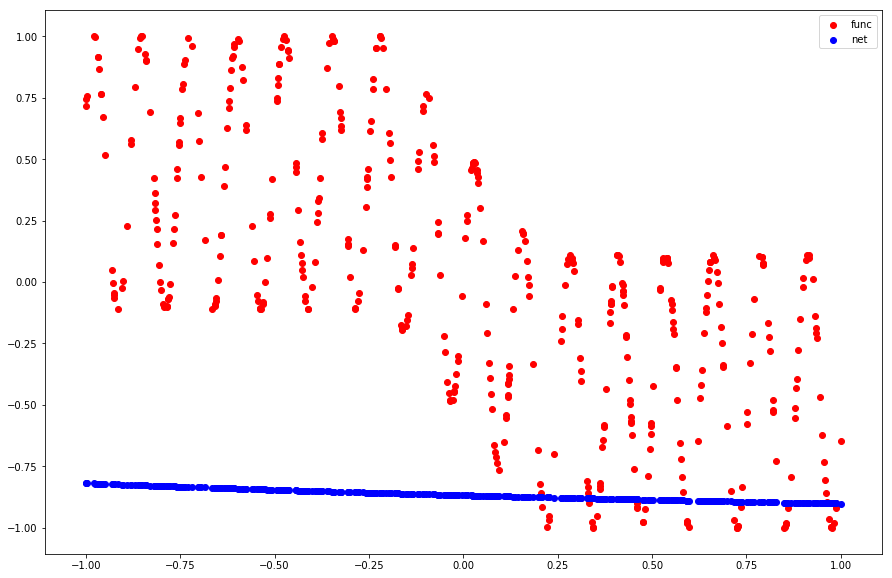

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(learn_data[:, 0], learn_data[:, 1], c='r', label='func')

inputs = autograd.Variable((torch.from_numpy(learn_data[:, 0]).float()).unsqueeze(1))
predict = net.forward(inputs).data.numpy()
plt.scatter(learn_data[:, 0], predict, c='b', label='net')
plt.legend()
plt.savefig('before_training.png', bbox_inches='tight')

In [16]:
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
l1w = []
l2w = []
l1b = []
l2b = []
num_epoh = []
loss_epoh = []
valid_loss_epoh = []
test_loss_epoh = []
for epoh in range(10**6):
    if epoh % 10000 == 0:
        print("epoh", epoh)
    loss_acc = 0
    for mini_batch in dataloader:
        learn_inputs = autograd.Variable(mini_batch[:, 0].float()).unsqueeze(1)
        learn_labels = autograd.Variable(mini_batch[:, 1].float()).unsqueeze(1)
        
        optimizer.zero_grad()
        learn_output = net(learn_inputs)
        loss = criterion(learn_output, learn_labels)
        loss.backward()
        optimizer.step()
        loss_acc += loss.data[0]
    loss_epoh.append(loss_acc / len(learn_data))
    
    valid_inputs = autograd.Variable(torch.from_numpy(valid_data[:, 0]).float()).unsqueeze(1)
    valid_labels = autograd.Variable(torch.from_numpy(valid_data[:, 1]).float()).unsqueeze(1)
    test_inputs = autograd.Variable(torch.from_numpy(test_data[:, 0]).float()).unsqueeze(1)
    test_labels = autograd.Variable(torch.from_numpy(test_data[:, 1]).float()).unsqueeze(1)
    valid_output = net(valid_inputs)
    valid_loss = criterion(valid_output, valid_labels).data.numpy()
    test_output = net(test_inputs)
    test_loss = criterion(test_output, test_labels).data.numpy()
    valid_loss_epoh.append(np.sum(valid_loss) / len(valid_data))
    test_loss_epoh.append(np.sum(test_loss) / len(test_data))

    if epoh % 10000 == 0:
        num_epoh.append(epoh)
        for num, i in enumerate(net.parameters()):
            if num == 0:
                l1w.append(np.copy(i.data.numpy()))
            if num == 1:
                l2w.append(np.copy(i.data.numpy()))
            if num == 2:
                l1b.append(np.copy(i.data.numpy()))
            if num == 3:
                l2b.append(np.copy(i.data.numpy()))

epoh 0
epoh 10000
epoh 20000
epoh 30000
epoh 40000
epoh 50000
epoh 60000
epoh 70000
epoh 80000
epoh 90000
epoh 100000
epoh 110000
epoh 120000
epoh 130000
epoh 140000
epoh 150000
epoh 160000
epoh 170000
epoh 180000
epoh 190000
epoh 200000
epoh 210000
epoh 220000
epoh 230000
epoh 240000
epoh 250000
epoh 260000
epoh 270000
epoh 280000
epoh 290000
epoh 300000
epoh 310000
epoh 320000
epoh 330000
epoh 340000
epoh 350000
epoh 360000
epoh 370000
epoh 380000
epoh 390000
epoh 400000
epoh 410000
epoh 420000
epoh 430000
epoh 440000
epoh 450000
epoh 460000
epoh 470000
epoh 480000
epoh 490000
epoh 500000
epoh 510000
epoh 520000
epoh 530000
epoh 540000
epoh 550000
epoh 560000
epoh 570000
epoh 580000
epoh 590000
epoh 600000
epoh 610000
epoh 620000
epoh 630000
epoh 640000
epoh 650000
epoh 660000
epoh 670000
epoh 680000
epoh 690000
epoh 700000
epoh 710000
epoh 720000
epoh 730000
epoh 740000
epoh 750000
epoh 760000
epoh 770000
epoh 780000
epoh 790000
epoh 800000
epoh 810000
epoh 820000
epoh 830000
epoh 8

In [18]:
l1w = np.array(l1w)
l2w = np.array(l2w)
l1b = np.array(l1b)
l2b = np.array(l2b)
l2b.shape

(100, 1)

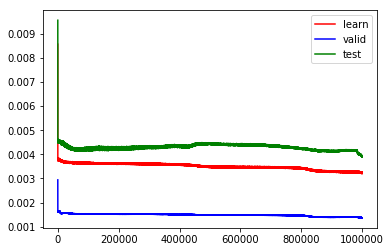

In [19]:
plt.plot(loss_epoh, color='r', label = 'learn')
plt.plot(valid_loss_epoh, color='b', label = 'valid')
plt.plot(test_loss_epoh, color='g', label = 'test')
plt.legend()
plt.savefig('train_valid_test.png', bbox_inches='tight')

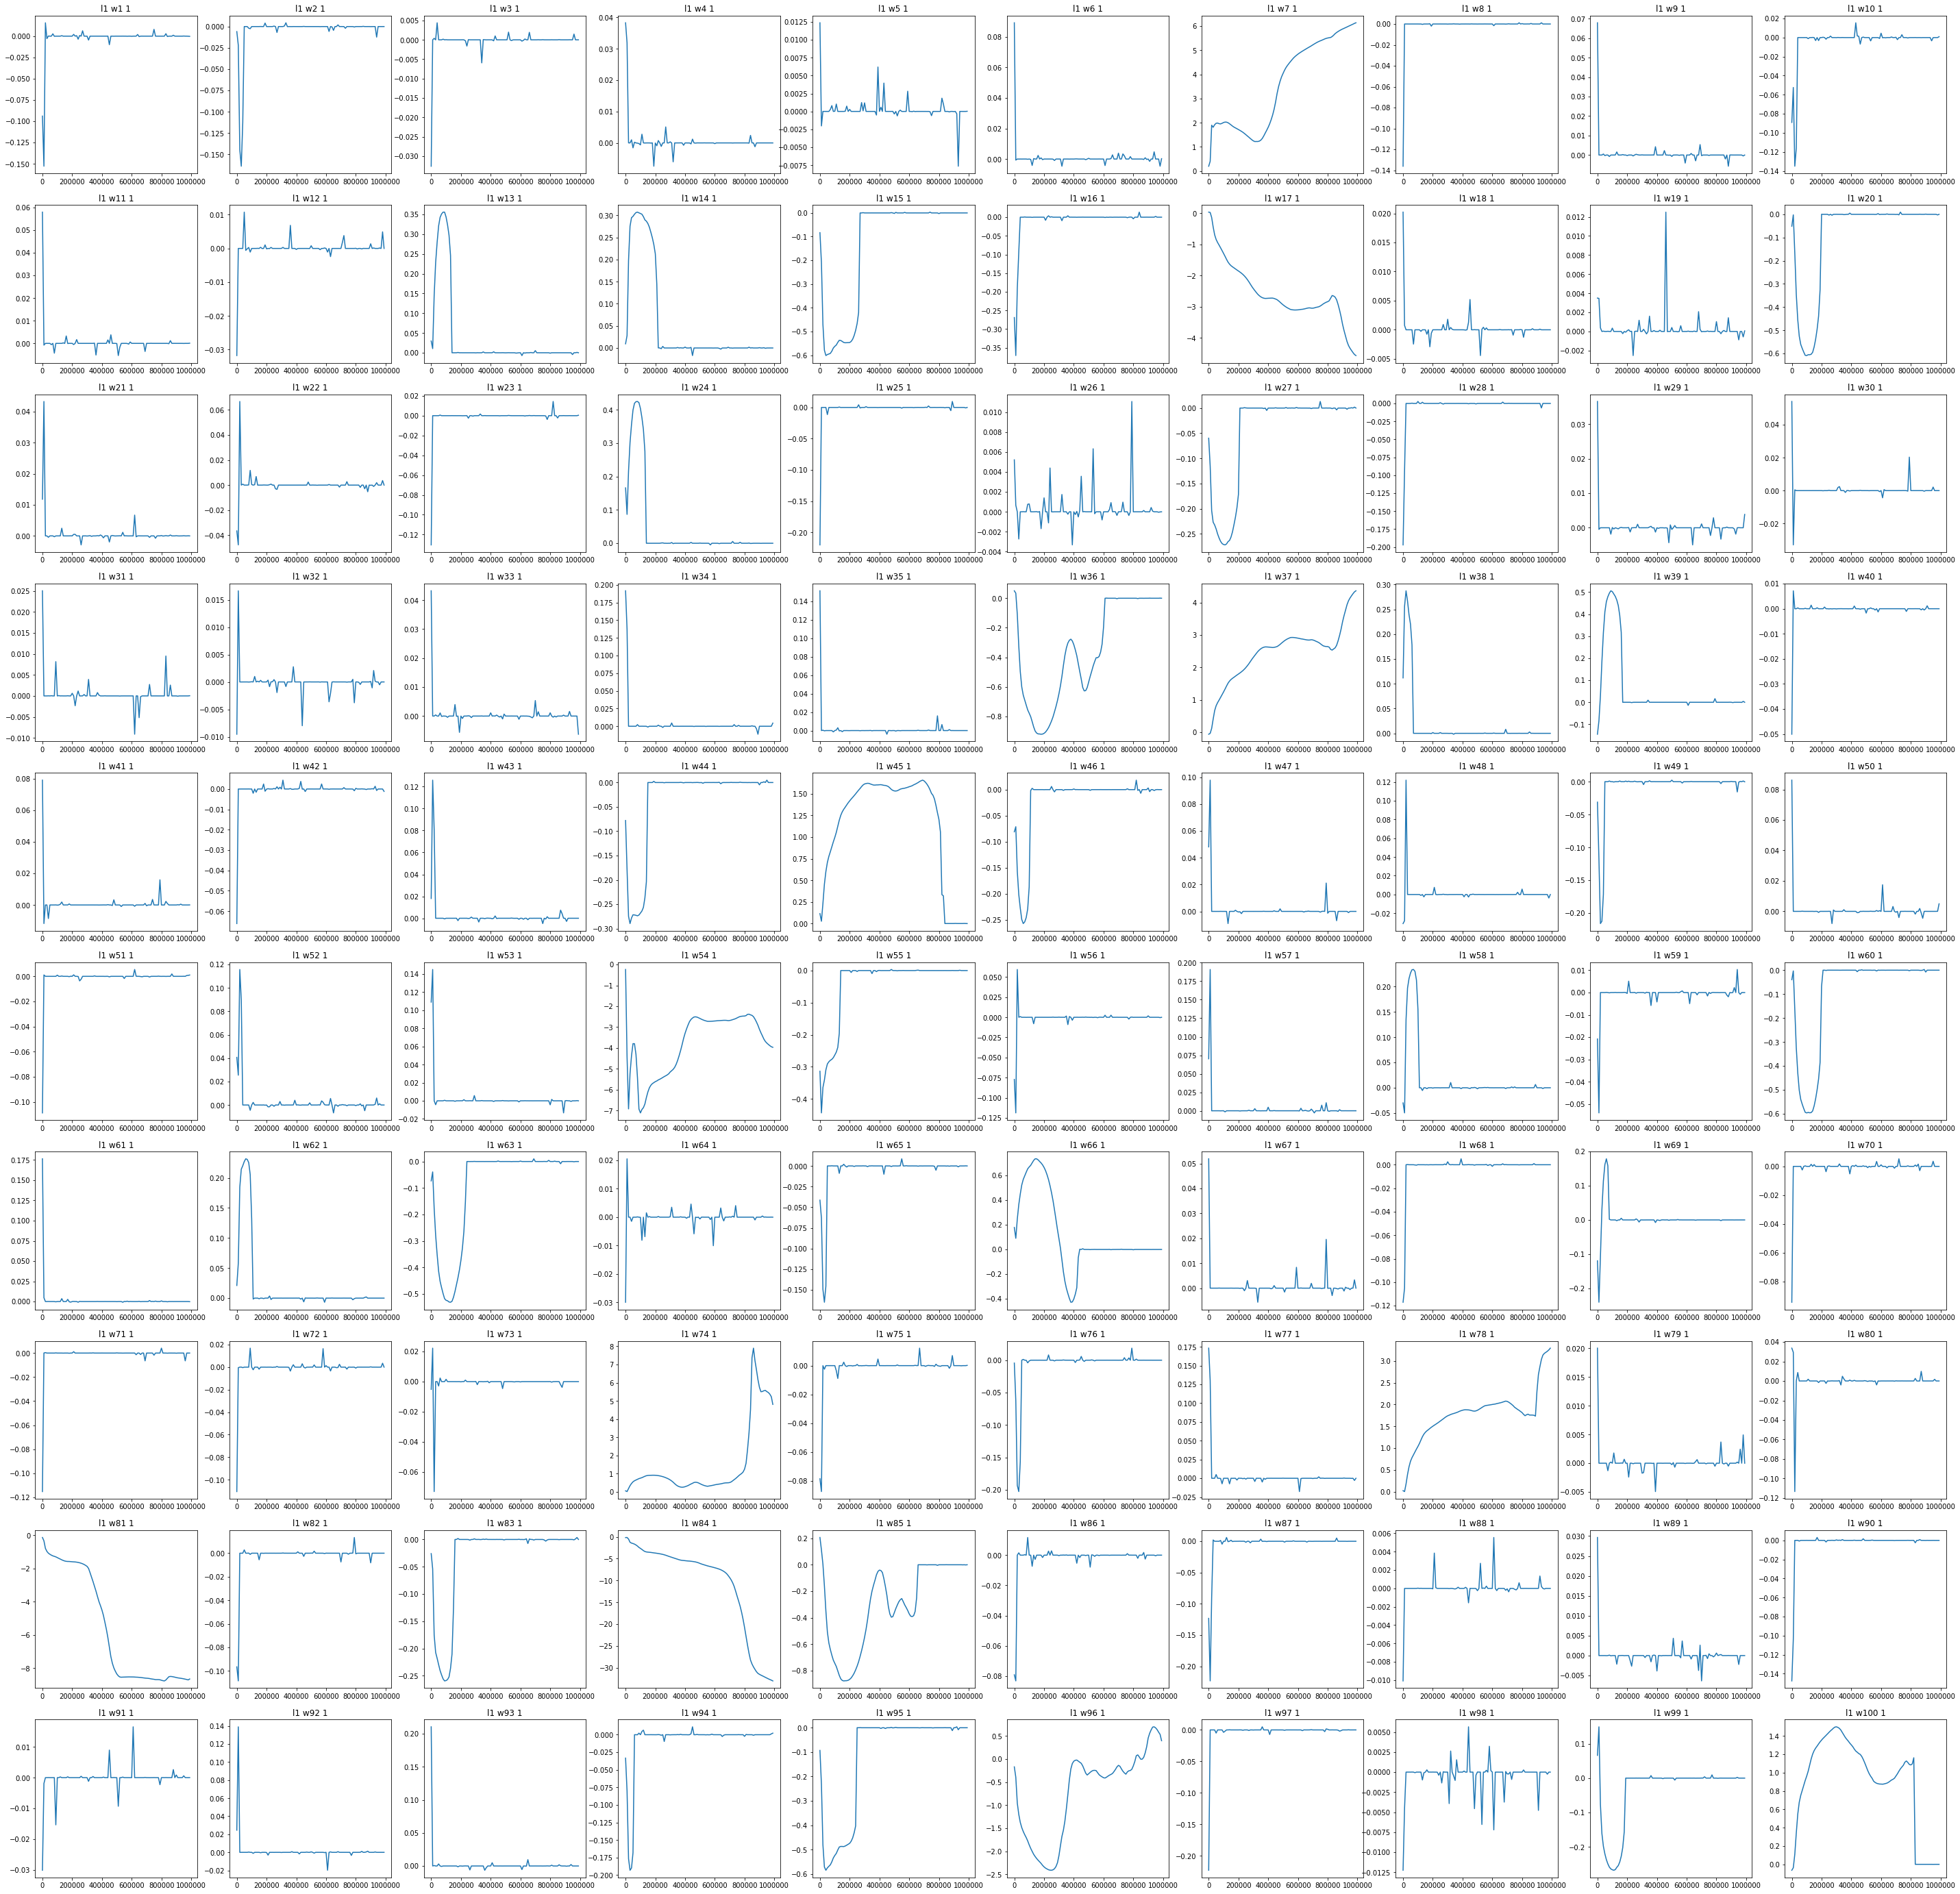

In [20]:
plt.figure(figsize=(50,50))
for i in range(100):
    plt.subplot(10, 10, 1 + i )
    plt.plot(num_epoh, l1w[:, i, 0])
    plt.title('l1 w' + str(i+1)+' 1')
plt.savefig('l1w.png', bbox_inches='tight')

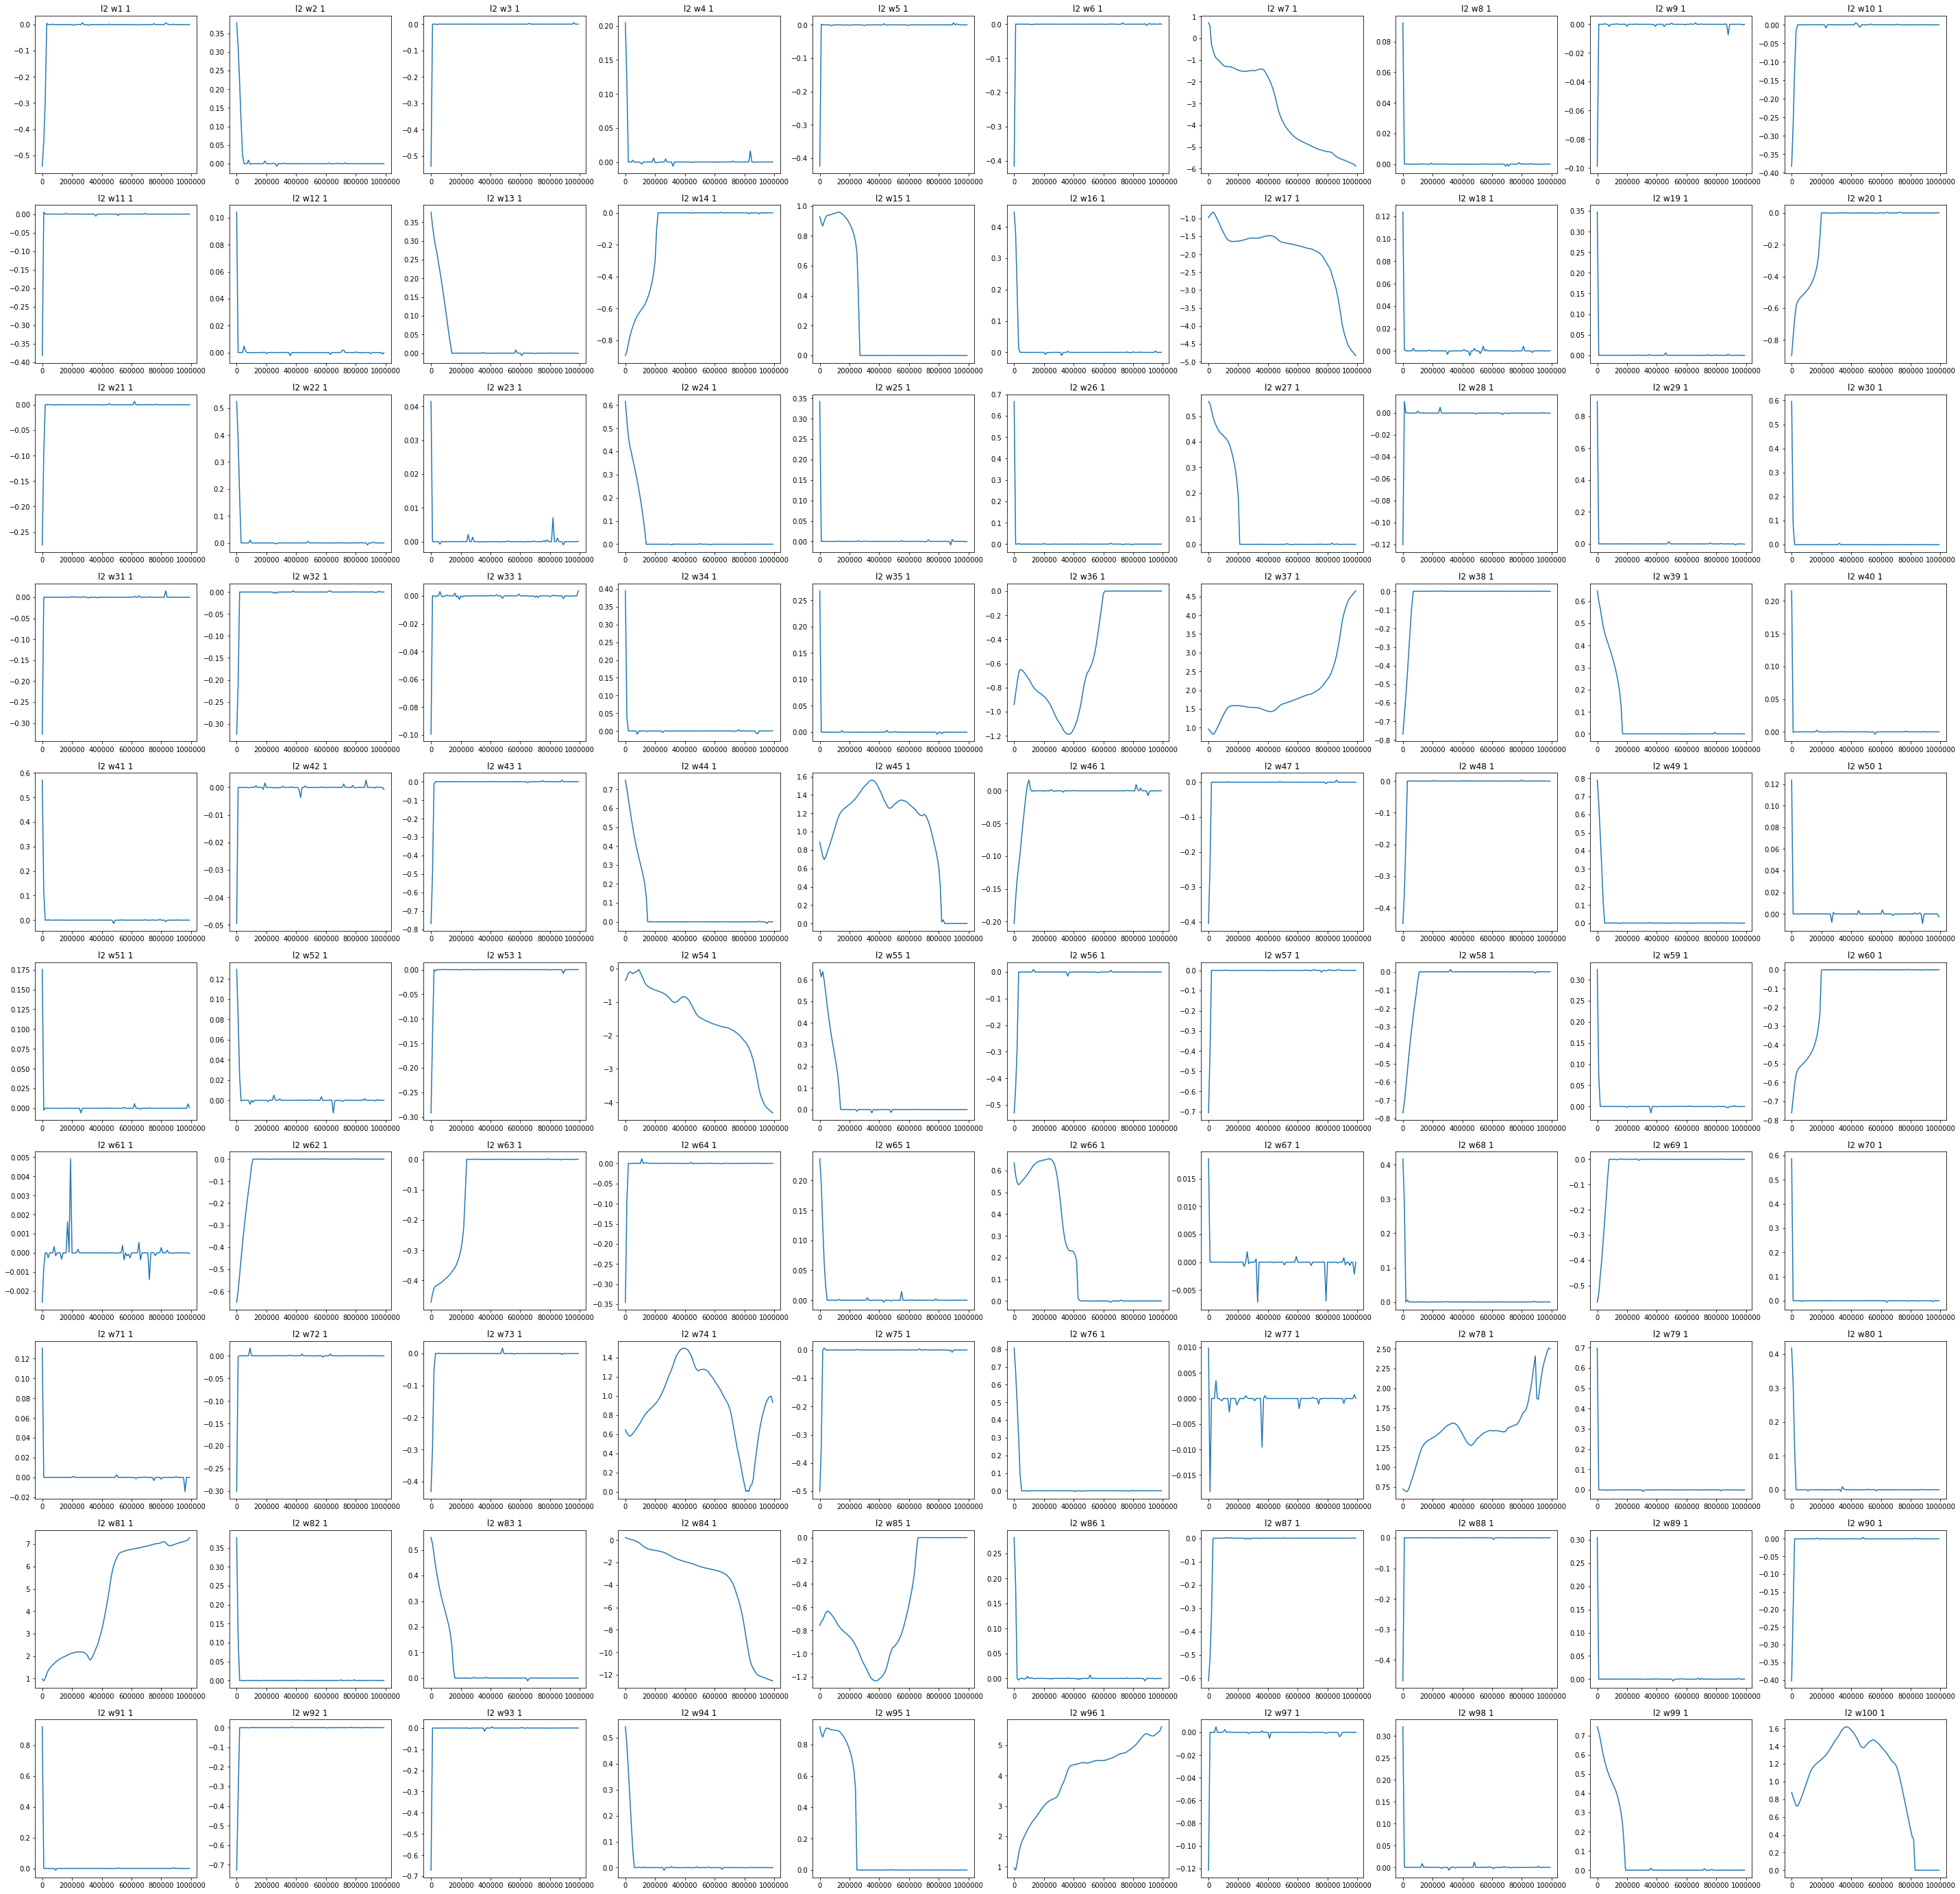

In [21]:
plt.figure(figsize=(50,50))
for i in range(100):
    plt.subplot(10, 10, 1 + i )
    plt.plot(num_epoh, l2w[:, i])
    plt.title('l2 w' + str(i+1)+' 1')
plt.savefig('l2w.png', bbox_inches='tight')

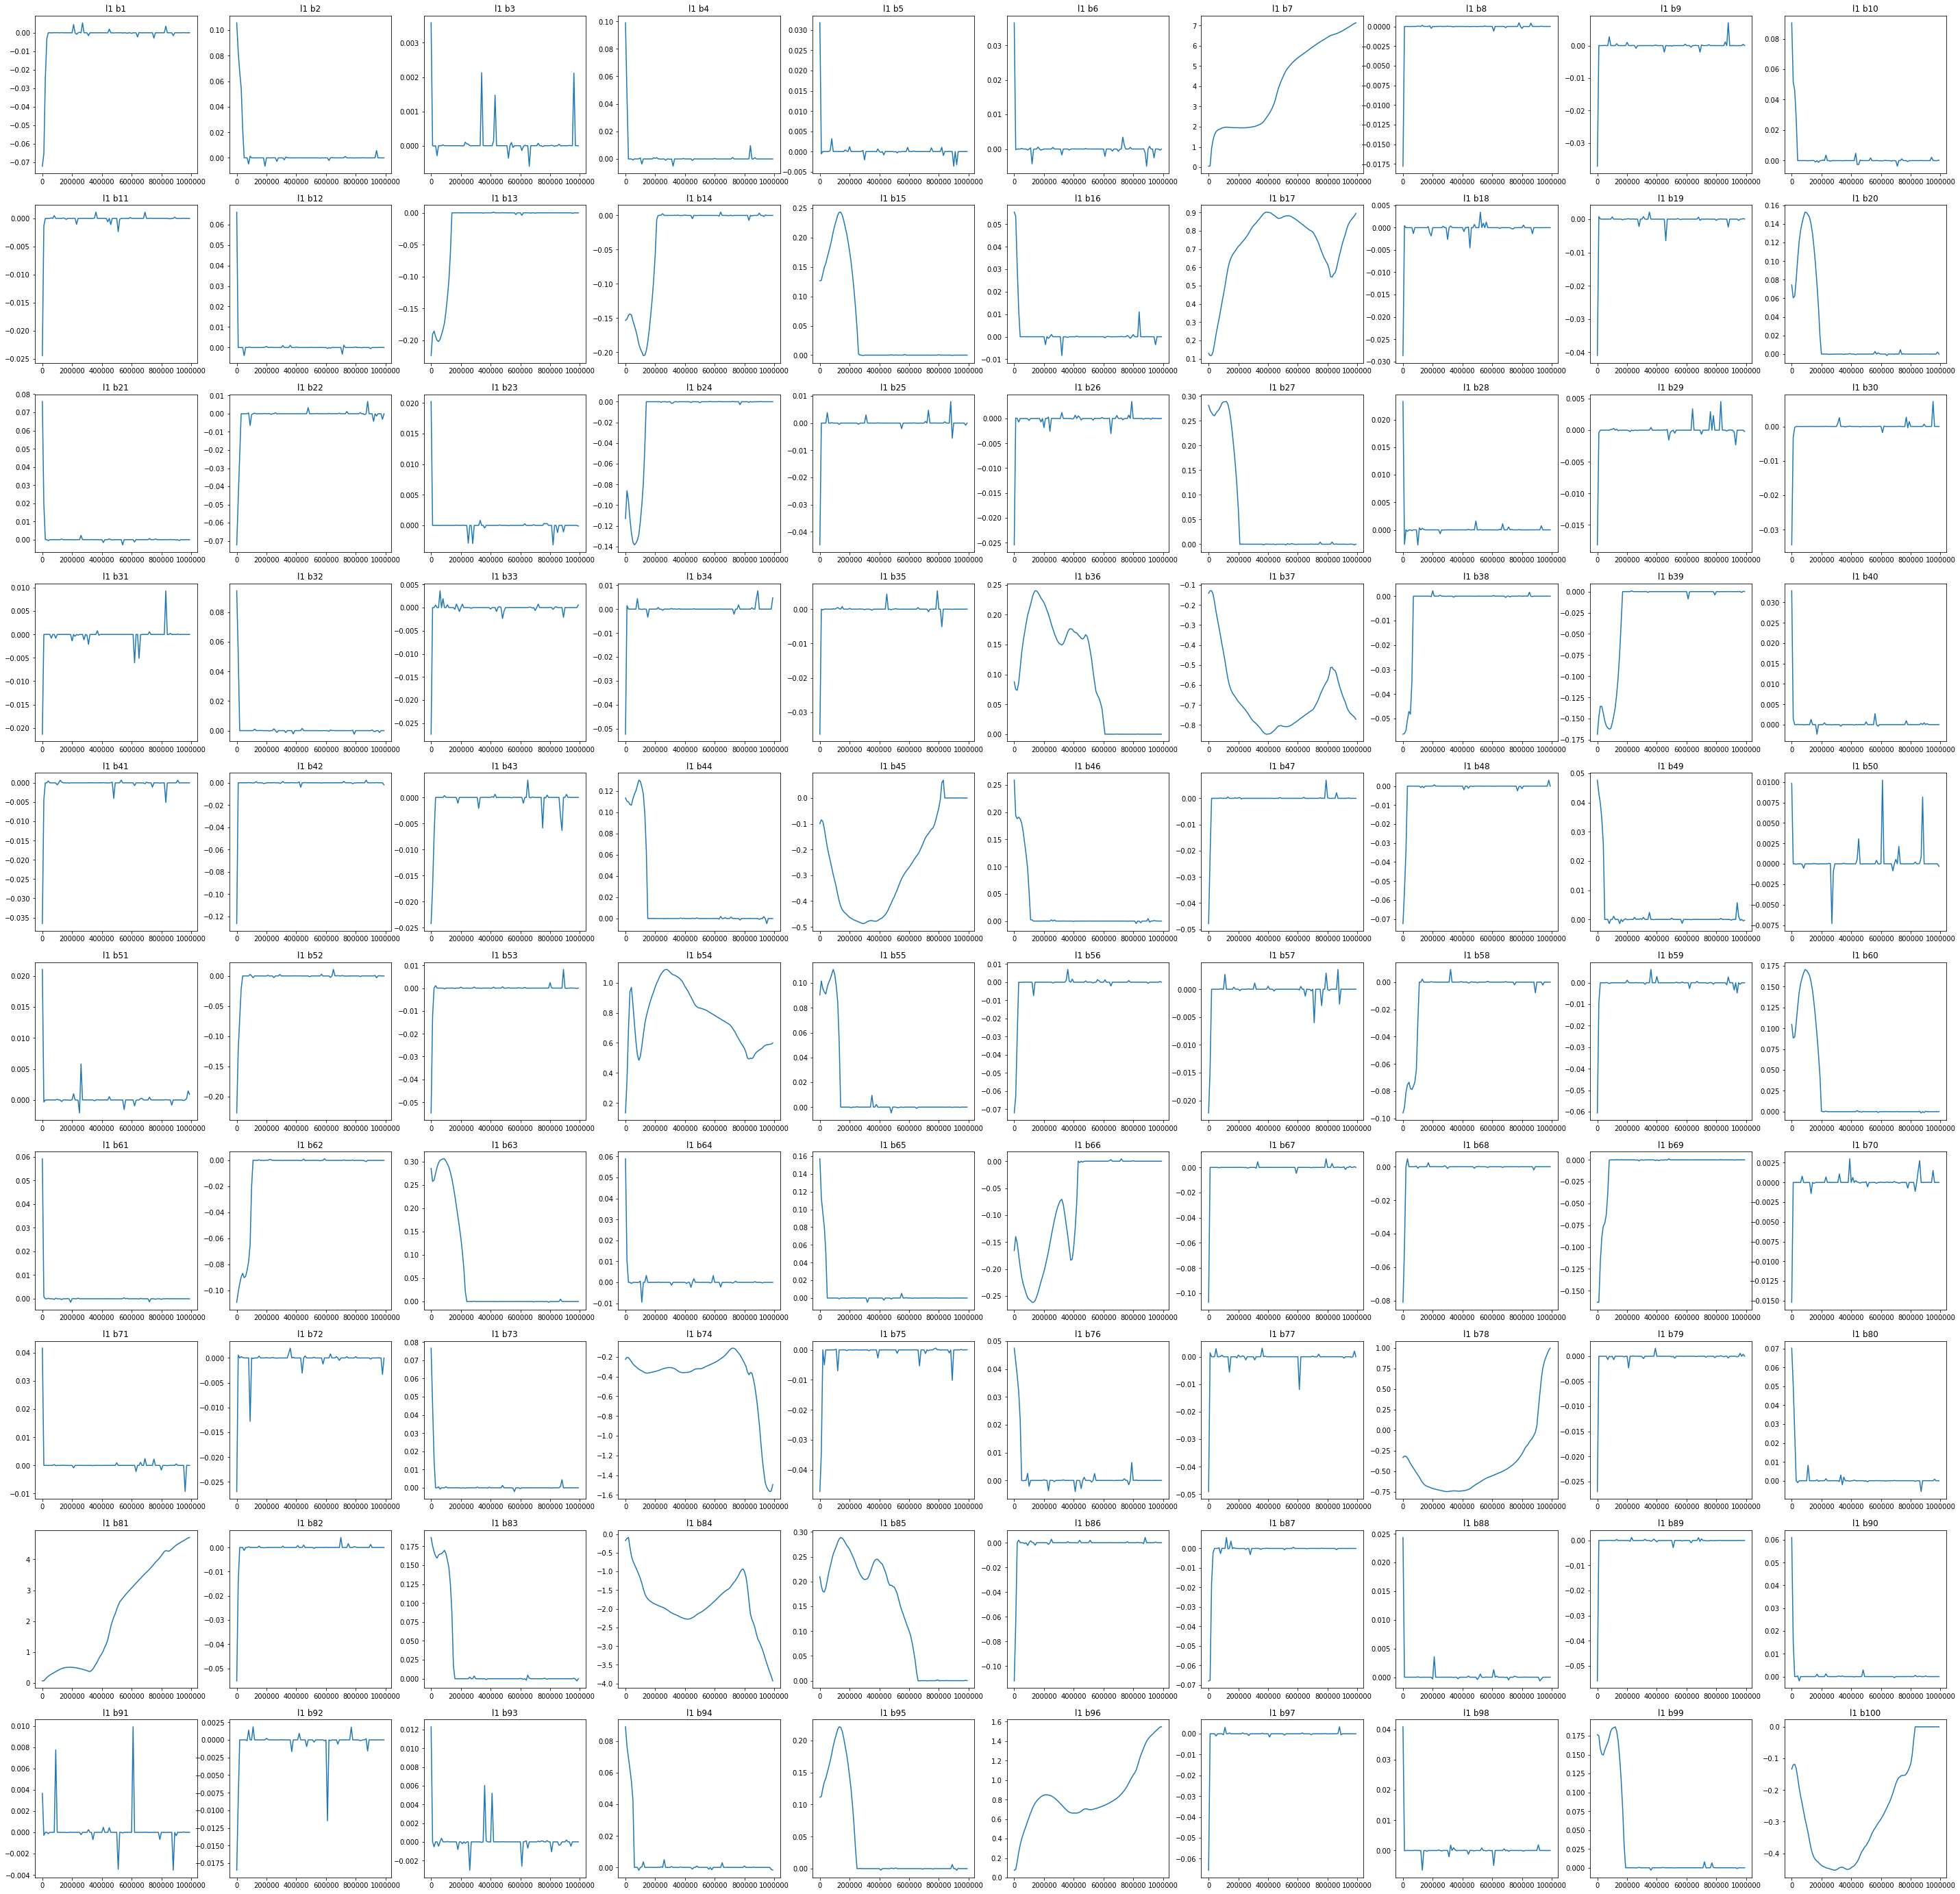

In [22]:
plt.figure(figsize=(50,50))
for i in range(100):
    plt.subplot(10, 10, 1 + i )
    plt.plot(num_epoh, l1b[:, 0, i])
    plt.title('l1 b' + str(i+1))
plt.savefig('l1b.png', bbox_inches='tight')

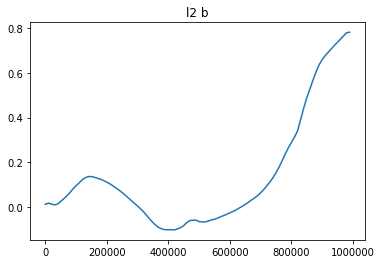

In [23]:
plt.plot(num_epoh, l2b[:, 0])
plt.title('l2 b')
plt.savefig('l2b.png', bbox_inches='tight')

In [24]:
print("learn:")
print(max(loss_epoh))
print(math.sqrt(np.var(loss_epoh)))
print(math.sqrt(np.mean(loss_epoh)))

print("valid:")
print(max(valid_loss_epoh))
print(math.sqrt(np.var(valid_loss_epoh)))
print(math.sqrt(np.mean(valid_loss_epoh)))

print("test:")
print(max(test_loss_epoh))
print(math.sqrt(np.var(test_loss_epoh)))
print(math.sqrt(np.mean(test_loss_epoh)))

learn:
0.008560271064440409
0.0001234850788635605
0.05916687730477892
valid:
0.002942982067664464
4.753817301175116e-05
0.038568503194010444
test:
0.009550084173679353
0.0001011358199328182
0.06549675869363578


[-0.99383986] [0.87270236]


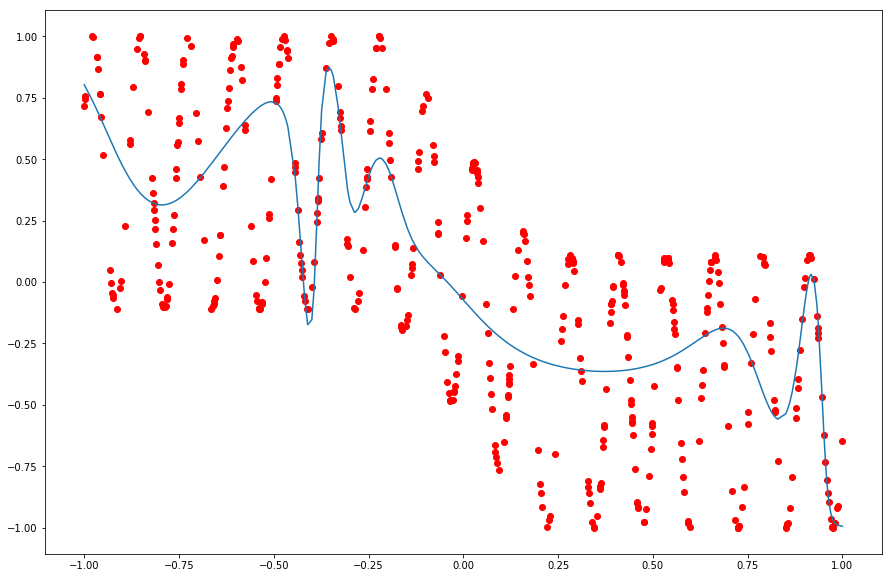

In [25]:
df_buf = pd.DataFrame(dataset.data)
df_buf = df_buf.sort_values(by=0)

x = autograd.Variable((torch.from_numpy(df_buf.get_values()[:, 0]).float()).unsqueeze(1))
y = net.forward(x)
x = x.data.numpy()
y = y.data.numpy()
print(min(y), max(y))
plt.figure(figsize=(15,10))
plt.scatter(learn_data[:,0], learn_data[:,1], color='r')
plt.plot(x, y)
plt.savefig('learndot.png', bbox_inches='tight')